In [1]:
import pandas as pd
import numpy as np
from math import *
from random import *
import datetime as datetime
import matplotlib.pyplot as plt
import math
from numpy import unravel_index
from PointProcess import PointProcessTrain
from PointProcess import PointProcessRun
from wasserstein import Cluster
from numpy import array
from scipy import linalg as la
from haversine import haversine

In [2]:
fields = ['XCOORD', 'YCOORD', 'CALL_TYPE_FINAL_D', 'CALL_TYPE_FINAL', 'DATE_TIME']
full_data = pd.read_csv('FixedLatLongTimeLoc_AndTimeSorted.csv', usecols=fields)
full_data['DATE_TIME'] =  pd.to_datetime(full_data['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
full_data = full_data.sort_values(by='DATE_TIME')

In [3]:
em = full_data.values
em = em [:,2:4]

In [4]:
ems_locs = [[39.8260114,-86.0761364], [39.6568599,-86.1601396], [39.7732962,-86.1041378], 
            [39.7368328,-86.1503765], [39.8123208,-86.2047758], [39.8316109,-86.1467804], 
            [39.7827679,-85.9779839], [39.7520358,-86.0286547], [39.810177,-86.0407634], 
            [39.6779709,-86.0644407], [39.6513072,-86.0557181], [39.800967,-86.2618977], 
            [39.8329387,-85.9938128], [39.7509044,-86.1431251], [39.9087467,-86.1866223], 
            [39.795554,-86.1695443],  [39.8263546,-86.1058871], [39.7668563,-86.1321774], 
            [39.8540269,-86.200319], [39.6794523,-86.0208083],  [39.8902542,-86.0448717], 
            [39.7664619,-86.2092232], [39.7874424,-86.0773693], [39.8835439,-86.1220856], [39.6938768,-86.1408689]]
ems_locs = np.array (ems_locs)

In [5]:
#assume 1/2 of the stations will have immovable ambulances

In [112]:
print ((full_data['DATE_TIME'] [st+100] - full_data['DATE_TIME'] [st]).total_seconds() / (15 * 60)) 
print ((full_data['DATE_TIME'] [st+100] - full_data['DATE_TIME'] [st])) 

27.815555555555555
0 days 06:57:14


In [34]:
interval_count = 28
st = len(full_data) - 8000
PointProcess = PointProcessRun(param_location = 'Trained_Params_.npz')
start_time = full_data['DATE_TIME'] [st]
grid_loc = PointProcess.locs_for_wasserstein (start_time, interval_count, top_percent = 80)

In [35]:
mx = 100
#still_data = ems_locs [21:26]
move_data = ems_locs #[0:21]
cluster = Cluster(grid_loc, n = len(move_data))
cluster.set_centers (move_data, n = len(move_data))
#cluster.remove_points (still_data)
lam = cluster.learn_lam(n_iter = 5, rand_centers = False)
#cluster.round_off()
#cluster.process_data_kmeans(True)
centers = cluster.get_centers()
data = cluster.get_data()

[1.0687152409286262, 350.0]
[1.0640209956432916, 370.0]
[1.0533490458184127, 389.0]
[1.0679507312278211, 407.0]
[1.0742832097650004, 403.0]


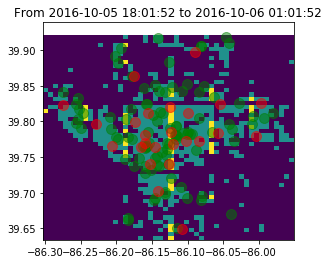

In [36]:
bincount = 50
data = grid_loc
end_time = start_time + datetime.timedelta(seconds = 15*60*interval_count)
heatmap, xedges, yedges = np.histogram2d(data[:,1], data[:,0], bins = bincount)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title ('From {} to {}'.format(str(start_time), str(end_time)))
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.scatter(em[st:st+mx,1], em[st:st+mx,0], c = 'green', s = 100, alpha = 0.5)
plt.scatter(centers[:,1], centers[:,0], c = 'red', s= 100, alpha = 0.5)
#plt.scatter(still_data[:,1], still_data[:,0], c = 'blue', s = 100, alpha = 0.5)
#plt.scatter(ems_locs[13:26,1], ems_locs[13:26,0], c = 'red', s = 100, alpha = 0.5)
plt.show()
plt.close()

[1.0898499613723374, 350.0]
[1.0783834003761459, 370.0]
[1.078981080491494, 389.0]
[1.0799110408166914, 386.0]
[1.0934837835016458, 389.0]


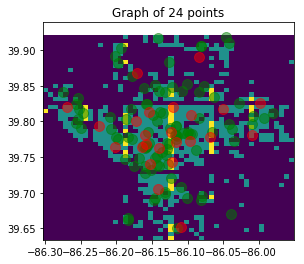

[1.1069695632167524, 350.0]
[1.1063265574058785, 370.0]
[1.135109152253094, 389.0]
[1.1058914674148734, 386.0]
[1.1745581909707101, 381.5]


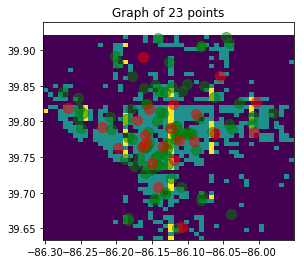

[1.1602147932573579, 350.0]
[1.1577675768027957, 370.0]
[1.127545980878221, 389.0]
[1.1567492795245309, 407.0]


In [ ]:
all_driving = np.empty ([0])
tp_rm_any = False
for x in range (mx):    
    emergency = [0,0]
    emergency [1] = full_data ['XCOORD'] [st + x]
    emergency [0] = full_data ['YCOORD'] [st + x]
    '''
    update = [{
        'XCOORD': full_data ['XCOORD'] [st + x],
        'YCOORD': full_data ['YCOORD'] [st + x],
        'DATE_TIME': full_data ['DATE_TIME'] [st + x]
    }]
    
    update = pd.DataFrame (update)
    '''
    #PointProcess.update_from_new_inputs(update, save_out = False)
    grid_loc = PointProcess.locs_for_wasserstein (start_time, interval_count, top_percent = 80)
    
    #total_data = np.concatenate ((centers, still_data))
    total_data = centers

    #find closest center
    mindist = 9999
    for i in range (len(total_data)):
        dist = la.norm (total_data [i, 0:2] - emergency)
        if (dist < mindist):
            mindist = dist
            truck_point = total_data [i, 0:2]
            pos = i
            
    if (x % (mx / 10) == 0):
        start_time = full_data['DATE_TIME'] [st+x]
        #remove from either the movable or immovable points
        if (pos < len(centers)):
            centers = np.delete (centers, pos, 0)
            total_data = np.delete (total_data, pos, 0)
        else:
            still_data = np.delete (still_data, pos - len(centers), 0)
            total_data = np.delete (total_data, pos, 0)
            
        #total_data = np.concatenate ((centers, ems_locs[0:13]))
        tp_rm_any = True
        tp_rm = truck_point
        
        cluster = Cluster(grid_loc, n = len(centers))
        #cluster.remove_points (still_data)
        cluster.set_centers (centers[:,0:2], len(centers))
        lam = cluster.learn_lam(n_iter = 5, rand_centers = False)
        #cluster.round_off()
        #cluster.process_data_kmeans(True)
        centers = cluster.get_centers()
        data = cluster.get_data()
        
        heatmap, xedges, yedges = np.histogram2d(data[:,1], data[:,0], bins = bincount)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
        plt.clf()
        plt.title ('Graph of {} points'.format(str(len(total_data))))
        plt.imshow(heatmap.T, extent=extent, origin='lower')
        plt.scatter(em[st+x:st+mx,1], em[st+x:st+mx,0], c = 'green', s = 100, alpha = 0.5)
        plt.scatter(centers[:,1], centers[:,0], c = 'red', s = 100, alpha = 0.5)
        #plt.scatter(still_data[:,1], still_data[:,0], c = 'blue', s = 100, alpha = 0.5)
        plt.show()
        plt.close()
        
        #find driving distance to that point
    driving_distance = cluster.driving_distance (emergency, truck_point)
    #driving_distance = haversine (emergency, truck_point, miles = True)
    all_driving = np.append (all_driving, driving_distance)

In [31]:
''' 
##########
# FOR NO CLUSTERING
##########
''' 
interval_count = 28
st = len(full_data) - 8000
PointProcess = PointProcessRun(param_location = 'Trained_Params_.npz')
start_time = full_data['DATE_TIME'] [st]
grid_loc = PointProcess.locs_for_wasserstein (start_time, interval_count, top_percent = 80)

centers = ems_locs
all_driving = np.empty ([0])
tp_rm_any = False
for x in range (mx):    
    emergency = [0,0]
    emergency [1] = full_data ['XCOORD'] [st + x]
    emergency [0] = full_data ['YCOORD'] [st + x]
    
    #total_data = np.concatenate ((centers, still_data))
    total_data = centers
    
    #find closest center
    mindist = 9999
    for i in range (len(total_data)):
        dist = la.norm (total_data [i, 0:2] - emergency)
        if (dist < mindist):
            mindist = dist
            truck_point = total_data [i, 0:2]
            pos = i
            
    if (x % (mx / 10) == 0):
        start_time = full_data['DATE_TIME'] [st+x]
        #remove from either the movable or immovable points
        if (pos < len(centers)):
            centers = np.delete (centers, pos, 0)
            total_data = np.delete (total_data, pos, 0)
        else:
            still_data = np.delete (still_data, pos - len(centers), 0)
            total_data = np.delete (total_data, pos, 0)
            
        #total_data = np.concatenate ((centers, ems_locs[0:13]))
        tp_rm_any = True
        tp_rm = truck_point
        
    #find driving distance to that point
    driving_distance = cluster.driving_distance (emergency, truck_point)
    #driving_distance = haversine (emergency, truck_point, miles = True)
    all_driving = np.append (all_driving, driving_distance)

In [ ]:
all_driving = np.around(all_driving * 0.621371, decimals = 3)
#all_driving = np.around(all_driving, decimals = 3)
np.set_printoptions(suppress=True)
print (all_driving)
print (np.around (all_driving.mean(), decimals = 3))
print (np.around (np.median(all_driving), decimals = 3))
plt.plot(all_driving)

In [30]:
kmeans_rt = all_driving

In [ ]:
wass_rt = all_driving

In [33]:
none_rt = all_driving

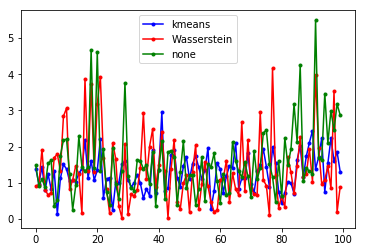

In [23]:
#round_rt = all_driving
plt.plot(kmeans_rt, 'b.-', label = 'kmeans')
plt.plot(wass_rt, 'r.-', label = 'Wasserstein')
plt.plot(none_rt, 'g.-', label = 'none')
plt.legend()

kmeans:  median:  1.2525 mean:  1.29162
wass:  median:  1.1225 mean:  1.35167
none:  median:  1.4264999999999999 mean:  1.58656


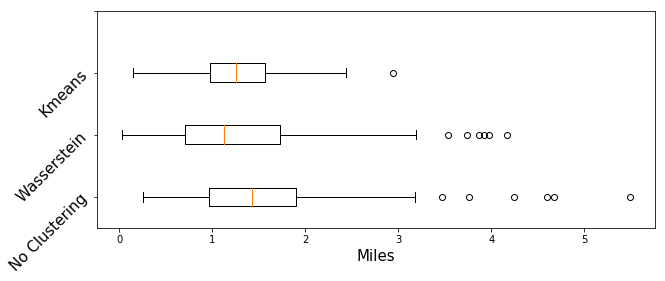

In [24]:
data = [kmeans_rt, wass_rt, none_rt]
print ('kmeans: ', 'median: ', np.median (kmeans_rt), 'mean: ', kmeans_rt.mean())
print ('wass: ', 'median: ', np.median (wass_rt), 'mean: ', wass_rt.mean())
print ('none: ', 'median: ', np.median (none_rt), 'mean: ', none_rt.mean())

labels=['',
        'Kmeans',
        'Wasserstein',
        'No Clustering']

x_pos = np.arange(4)

# Multiple box plots on one Axes
fig, ax = plt.subplots(figsize=(10,4))
bp = ax.boxplot(data, notch = 0, sym = '+', vert=0, whis=1.5)
plt.setp(bp['fliers'], color='red', marker='o')
ax.set_xlabel("Miles", fontsize = 15)
ax.set_yticks(x_pos)
ax.set_yticklabels(labels, rotation=45, fontsize = 15)
ax.invert_yaxis()
plt.show()

In [98]:
tosave = ax.get_figure()
tosave.savefig('Miles.png', bbox_inches='tight')

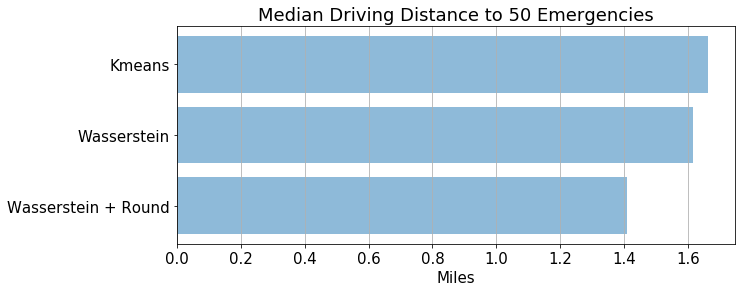

In [65]:
plt.rcParams.update({'font.size': 15, 'text.color' : "black",
                     'axes.labelcolor' : "black"})
labels=['Kmeans',
        'Wasserstein', 
        'Wasserstein + Round']

x_pos = np.arange(len(labels))
CTEs = [1.664,
        1.615, 
        1.408]

fig, ax = plt.subplots(figsize=(10,4))
# color=[11/255,122/255,117/255], 
ax.barh(x_pos, CTEs, alpha=0.5)
ax.set_xlabel("Miles")
ax.set_yticks(x_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()
#ax.set_title("Average PAI for 20 predicions over 1, 2, and 4 hours \nfor 50 by 50 grid (cell size of .16 mi^2)")
ax.xaxis.grid(True)
plt.title("Median Driving Distance to 50 Emergencies")
plt.show()